In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = (np.expand_dims(train_images, axis=-1) / 255).astype(np.float32)
train_labels = tf.keras.utils.to_categorical(
    train_labels, num_classes=10, dtype=np.int8)

test_images = (np.expand_dims(test_images, axis=-1) / 255).astype(np.float32)
test_labels = (test_labels).astype(np.int8)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels,
)

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(  
    rotation_range=10,  
    zoom_range=0.2, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
)

datagen.fit(train_images)

# AlderNet

In [5]:
class RootLayer(tf.keras.layers.Layer):
    def __init__(self, filters, gaussian_noise_ratio):
        super().__init__()
        self.conv7x7_2s = keras.layers.Conv2D(filters, 7, strides = 2, padding = 'same')
        self.conv3x3 = keras.layers.Conv2D(filters, 3, padding = 'same')
        self.conv3x3_2s = keras.layers.Conv2D(filters, 3, strides = 2, padding = 'same')
        self.conv5x5_2s = keras.layers.Conv2D(filters, 5, strides = 2, padding = 'same')
        self.conv1x1 = keras.layers.Conv2D(filters, 1, padding = 'same')
        
        self.act_relu = keras.layers.Activation(tf.nn.relu)
        self.batchnorm = keras.layers.BatchNormalization()
        self.gnoise = keras.layers.GaussianNoise(gaussian_noise_ratio)
        

    def call(self, inputs):
        root1 = self.conv7x7_2s(inputs)
        root1 = self.gnoise(root1)
        root1 = self.act_relu(root1)
        root1 = self.batchnorm(root1)
        
        root2 = self.conv3x3_2s(inputs)
        root2 = self.conv3x3(root2)
        root2 = self.gnoise(root2)
        root2 = self.act_relu(root2)
        root2 = self.batchnorm(root2)
        
        root3 = self.conv5x5_2s(inputs)
        root3 = self.conv1x1(root3)
        root3 = self.gnoise(root3)
        root3 = self.act_relu(root3)
        root3 = self.batchnorm(root3)
        
        root4 = self.conv3x3_2s(inputs)
        root4 = self.conv1x1(root4)
        root4 = self.act_relu(root4)
        root4 = self.batchnorm(root4)
        
        roots = keras.layers.Add()([root1, root2, root3, root4])
        return roots

In [6]:
class TrunkLayer(tf.keras.layers.Layer):
    def __init__(self, filters, gaussian_noise_ratio, gaussian_dropout_ratio):
        super().__init__()
        self.max_pool = keras.layers.MaxPool2D(pool_size=(3, 3), strides = 2, padding='same')
        self.conv3x3 = keras.layers.Conv2D(filters, 3, padding = 'same')
        self.conv1x1 = keras.layers.Conv2D(filters, 1, padding = 'same')
        
        self.act_relu = keras.layers.Activation(tf.nn.relu)
        self.batchnorm = keras.layers.BatchNormalization()
        self.gnoise = keras.layers.GaussianNoise(gaussian_noise_ratio)
        self.gdropout = tf.keras.layers.GaussianDropout(gaussian_dropout_ratio)
        self.multiply = keras.layers.Multiply()

    def call(self, inputs):
        trunk = self.max_pool(inputs)
        
        trunk1 = self.conv3x3(trunk)
        trunk1 = self.gdropout(trunk1)
        trunk1 = self.gnoise(trunk1)
        trunk1 = self.act_relu(trunk1)
        trunk1 = self.batchnorm(trunk1)
        
        trunk2 = self.conv3x3(trunk)
        trunk2 = self.conv1x1(trunk2)
        trunk2 = self.gdropout(trunk2)
        trunk2 = self.act_relu(trunk2)
        trunk2 = self.batchnorm(trunk2)
        
        trunk3 = self.conv3x3(trunk)
        trunk3 = self.conv3x3(trunk3)
        trunk3 = self.gdropout(trunk3)
        trunk3 = self.act_relu(trunk3)
        trunk3 = self.batchnorm(trunk3)
        
        t_m1 = self.multiply([trunk1, trunk2])
        t_m2 = self.multiply([trunk2, trunk3])
        trunk = keras.layers.Add()([t_m1, t_m2])
        return trunk

In [7]:
class FullyConnectedLayer(tf.keras.layers.Layer):
    def __init__(self, units, gaussian_dropout_ratio):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(units)
        self.gaussian_dropout = tf.keras.layers.GaussianDropout(gaussian_dropout_ratio)
        self.relu_leak = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.batchnorm = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense(x)
        x = self.gaussian_dropout(x)
        x = self.relu_leak(x)
        x = self.batchnorm(x)

        return x

In [8]:
class AlderNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.root_1 = RootLayer(filters = 256, gaussian_noise_ratio = 0.02)
        self.root_2 = RootLayer(filters = 256, gaussian_noise_ratio = 0.05)
        self.root_3 = RootLayer(filters = 256, gaussian_noise_ratio = 0.02)
        
        self.trunk = TrunkLayer(filters = 256, gaussian_noise_ratio = 0.02, gaussian_dropout_ratio=0.05)
        
        self.fully_connected = FullyConnectedLayer(units=128, gaussian_dropout_ratio=0.05)
        self.classification = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        root_1 = self.root_1(inputs)
        root_2 = self.root_2(inputs)
        root_3 = self.root_3(inputs)
        roots = keras.layers.Add()([root_1, root_2, root_3])

        trunk = self.trunk(roots)
        trunk = self.trunk(trunk)
        trunk = self.trunk(trunk)
        fully_connected = self.fully_connected(trunk)
        classification = self.classification(fully_connected)
        return classification

In [9]:
tf.random.set_seed(100)

In [10]:
BATCH_SIZE = 50
MAX_EPOCHS = 40

model = AlderNet()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', 
            patience=2, 
            verbose=1, 
            factor=0.5, 
            min_lr=1e-10,
        )
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )

history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE), 
          steps_per_epoch=len(train_images) / BATCH_SIZE,
          epochs=MAX_EPOCHS,
          validation_data=(val_images, val_labels),
          callbacks=[early_stopping, learning_rate_scheduler],
        )

2022-05-07 19:37:00.713218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:37:00.810592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:37:00.811345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 19:37:00.812513: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/40
1080/1080 [==============================] - 51s 44ms/step - loss: 0.7136 - accuracy: 0.7583 - val_loss: 2.9153 - val_accuracy: 0.4788
Epoch 2/40
1080/1080 [==============================] - 48s 44ms/step - loss: 0.1428 - accuracy: 0.9567 - val_loss: 6.3110 - val_accuracy: 0.4808
Epoch 3/40
1080/1080 [==============================] - 48s 44ms/step - loss: 0.1048 - accuracy: 0.9676 - val_loss: 0.9871 - val_accuracy: 0.7080
Epoch 4/40
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0906 - accuracy: 0.9732 - val_loss: 1.1346 - val_accuracy: 0.5340
Epoch 5/40
1080/1080 [==============================] - 48s 44ms/step - loss: 0.0817 - accuracy: 0.9756 - val_loss: 0.8149 - val_accuracy: 0.7335
Epoch 6/40
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0745 - accuracy: 0.9776 - val_loss: 0.3492 - val_accuracy: 0.9150
Epoch 7/40
1080/1080 [==============================] - 47s 44ms/step - loss: 0.0655 - accuracy: 0.9803 - val_loss: 0.5508 -

In [11]:
model.summary()

Model: "alder_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
root_layer (RootLayer)       multiple                  678912    
_________________________________________________________________
root_layer_1 (RootLayer)     multiple                  678912    
_________________________________________________________________
root_layer_2 (RootLayer)     multiple                  678912    
_________________________________________________________________
trunk_layer (TrunkLayer)     multiple                  656896    
_________________________________________________________________
fully_connected_layer (Fully multiple                  131712    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,826,634
Trainable params: 2,824,330
Non-trainable params: 2,304
___________________________________________

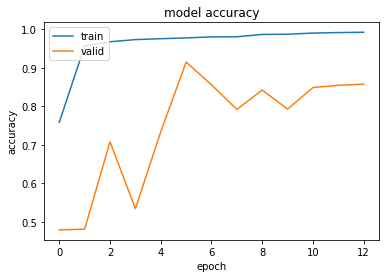

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

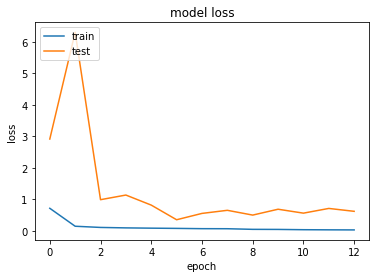

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
predictions = np.array(model.predict(test_images))

In [15]:
predicted_labels = np.array([np.argmax(row) for row in predictions])

In [16]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels, predicted_labels)
accuracy = accuracy.result().numpy()
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 92.08%


In [17]:
model.save(f'saved_model/')

2022-05-07 19:49:45.230320: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
